In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.decomposition import PCA

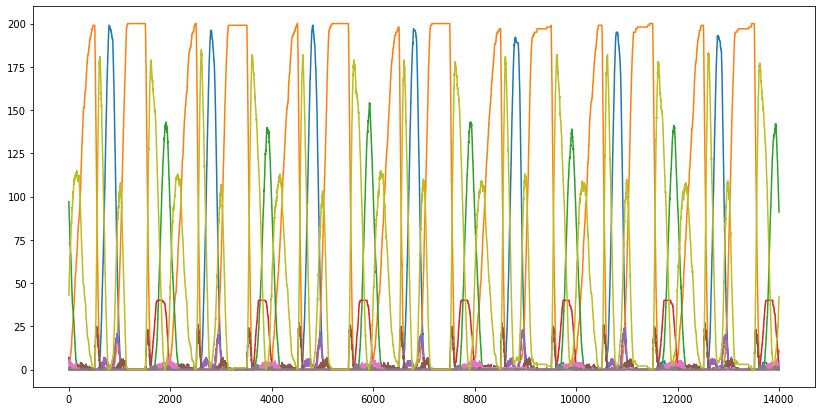

In [2]:
df_loaded = pd.read_csv("../data/MI_timesteps.txt", sep=" ", index_col=0)
plt.rcParams["figure.figsize"] = (14,7)
df = df_loaded.iloc[1000:]
df.index = df.index - 1000
for column in df.columns:
    plt.plot(df[column])
x_original = df.to_numpy()

## Part 1
Create a reasonable state space of the given system. It is periodic and has no parametric dependence,
so it probably will be a one-dimensional, closed loop. How many dimensions will you need to embed it
according to Takens theorem? Create a delay embedding with 350 delays of the first three measurement
areas (columns 2,3,4 in the file), this will create \windows" of 351 * 3 coordinates in the file, which you
then must turn into vectors of length 351 * 3 = 1053 dimensions. You can create many (M > 10000) of
these windows by starting in the first data row of the file (at time step 1), taking 351 lines for the first
window, and then moving down one row (i.e., to time step 2) to create the next window. Then, apply
PCA on that data set of M points of 1053 dimensions each, and use as many principal components as
necessary according to Takens.

It is periodic and has no parametric dependence,
so it probably will be a one-dimensional, closed loop. How many dimensions will you need to embed it
according to Takens theorem? **2d+1 = 3**

In [3]:
def create_delay_embedding(dataset, starting_row, num_delays=351):
    return dataset[starting_row:starting_row+num_delays, :].flatten()

(14001, 3)


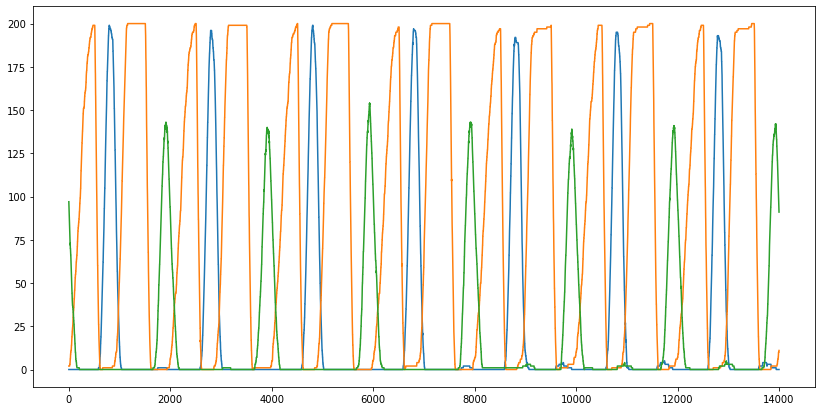

In [4]:
x_only_first_three = x_original[:,:3]
print(x_only_first_three.shape)
for i in range(x_only_first_three.shape[1]):
    plt.plot(x_only_first_three[:, i])

In [5]:
num_delays = 351
M = x_original.shape[0] - num_delays
M_dataset = np.empty(shape=(M, num_delays * x_only_first_three.shape[1]))
for i in range(M):
    M_dataset[i] = create_delay_embedding(x_only_first_three, starting_row=i, num_delays=num_delays)

In [6]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(M_dataset)

In [7]:
M_dataset.shape, x_pca.shape

((13650, 1053), (13650, 3))

## Part 2
In the embedding space you created in the first part, there are now many different points. Color the
points by all measurements taken at the first time point of the delays, for all nine measurement areas (you
have to create nine plots, where all the points will be in the same position, only the color changes). As an
example: if x original is an array of the original with points in its rows, and nine columns corresponding
to the nine measurements, and x pca is the array of the embedded points in PCA space, then you have to
make nine scatter plots, e.g. using Python: plt.scatter(*x pca.T, s=1, c=x original[:, i]), where
i=0,...8.

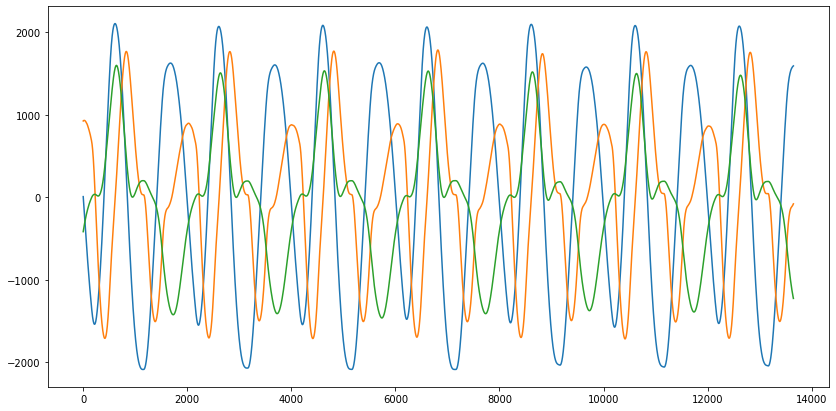

In [8]:
for i in range(x_pca.shape[1]):
    plt.plot(x_pca[:,i])

In [9]:
x_pca.shape, x_original.shape

((13650, 3), (14001, 9))

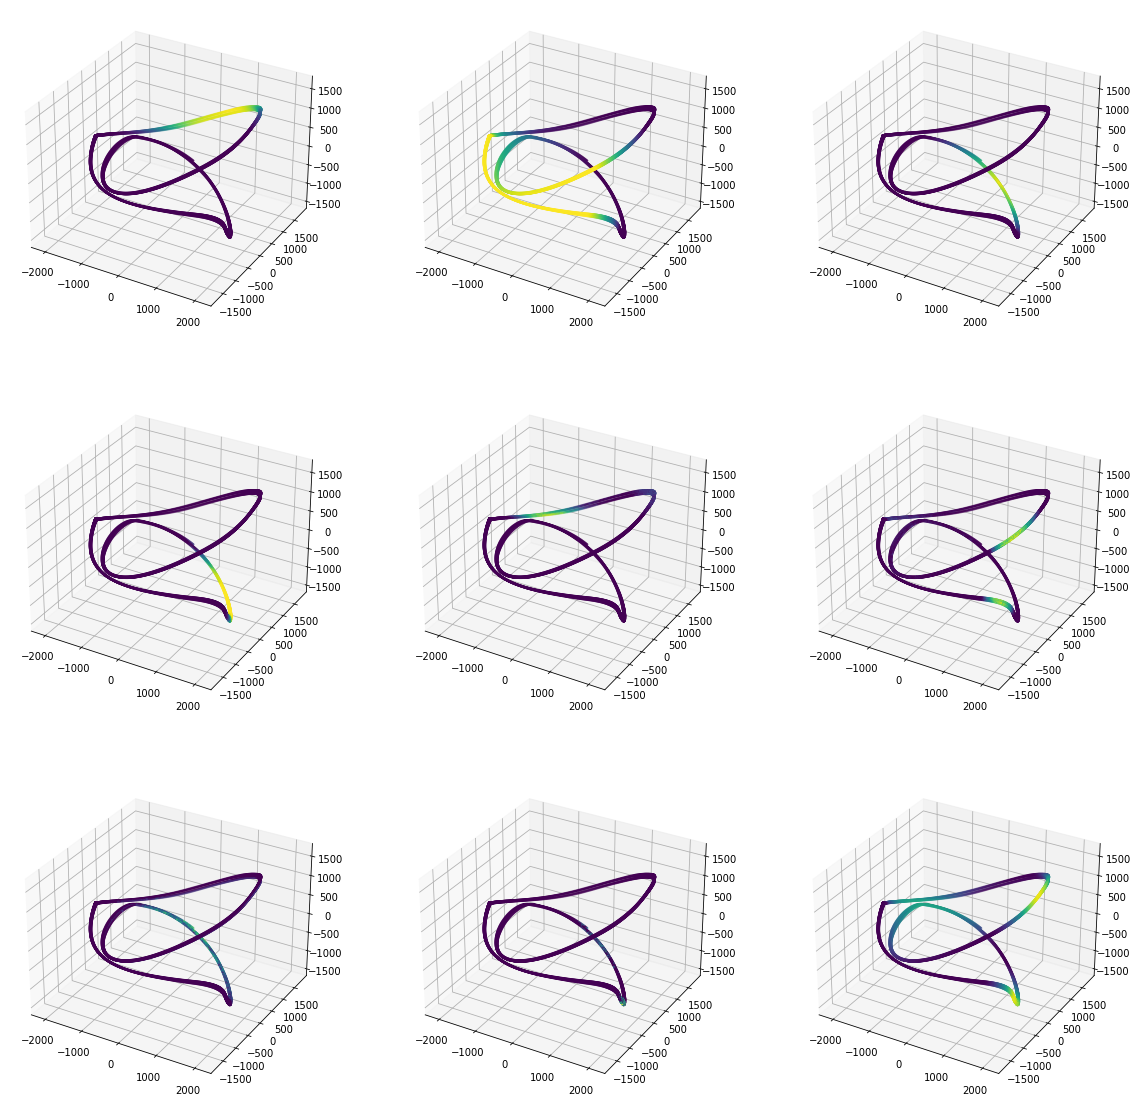

In [10]:
fig, axs = plt.subplots(3,3,figsize=(20,20), subplot_kw=dict(projection='3d'))
for i in range(9):
    axs[i // 3][i % 3].scatter(*x_pca.T, s=1, c=x_original[:M_dataset.shape[0], i])
plt.show()

## Part 3
Learn the dynamics on the periodic curve you embedded in the principal components. To do this, consider
the time step that is also available in the file, and determine how fast the system advances over the PCA
space at every point in the space. You know which point is the predecessor of which other point, since
all of them come from a single time series of measurements. Ideally, you compute the arclength of the
curve in the PCA space and then approximate the change of arclength over time: a vector field on the
arclength!

In [29]:
# search for the point of end period (fairly far from the starting point)
plt.rcParams["figure.figsize"] = (14,7)
lowest_dist, lowest_dist_idx = math.inf, -1
for i in range(x_pca.shape[0] -1):
    attempt_lowest_dist = np.linalg.norm(x_pca[i]-x_pca[0])
    if attempt_lowest_dist < lowest_dist and i > 100:
        lowest_dist = attempt_lowest_dist
        lowest_dist_idx = i

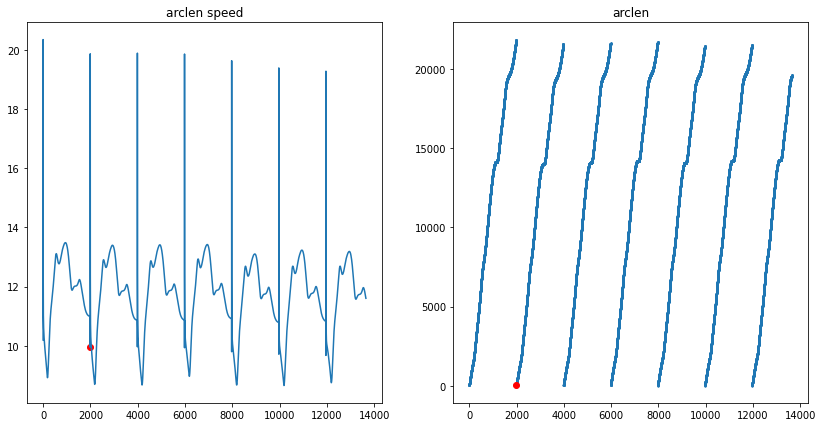

In [39]:
# show a plot to highlight the periodicity, zeroing the arclen and time passed when ending a period
%matplotlib inline
arclens = []
speeds = []
plt.rcParams["figure.figsize"] = (14,7)
cum_arclen = 0
periods = 0
for i in range(x_pca.shape[0] -1):
    if i != 0 and i % lowest_dist_idx == 0:
        cum_arclen = 0
        periods += 1
    dt = i - lowest_dist_idx*periods if i - lowest_dist_idx*periods > 0 else 1
    cum_arclen += np.linalg.norm(x_pca[i+1]-x_pca[i])
    arclens.append(cum_arclen)
    speeds.append(cum_arclen / dt)

fig, axs = plt.subplots(1,2)
axs[0].set_title("arclen speed")
axs[0].plot(speeds)
axs[0].scatter(lowest_dist_idx, speeds[lowest_dist_idx], c='red')
axs[1].set_title("arclen")
axs[1].scatter(range(len(arclens)), arclens, s=2)
axs[1].scatter(lowest_dist_idx, arclens[lowest_dist_idx], c='red')

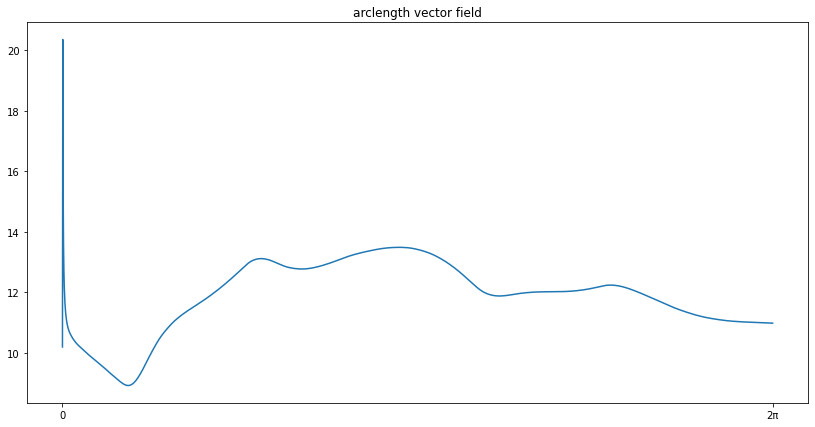

In [69]:
# create the final vector field, showing a single period
period_speeds = speeds[:lowest_dist_idx]
period_speeds_x = [i * 2 * math.pi / len(period_speeds) for i in range(len(period_speeds))]
plt.plot(period_speeds_x, period_speeds)
plt.title("arclength vector field")
plt.xticks([0, 6.28], ['0', '2π'], rotation='horizontal')
plt.show()

## Part 4
Predict the utilization of the MI building (first measurement area, first column in the file after the time
steps) for the next 14 days with your system, and plot the results over time. Compare the results with
the given data. The prediction can be done very easily by integrating the learned vector field on the
one-dimensional (but periodic!) space. Once you have the arclength values over time, create a mapping
back to the original utilization value by using radial basis function approximation from arclength space
to the utilization value.

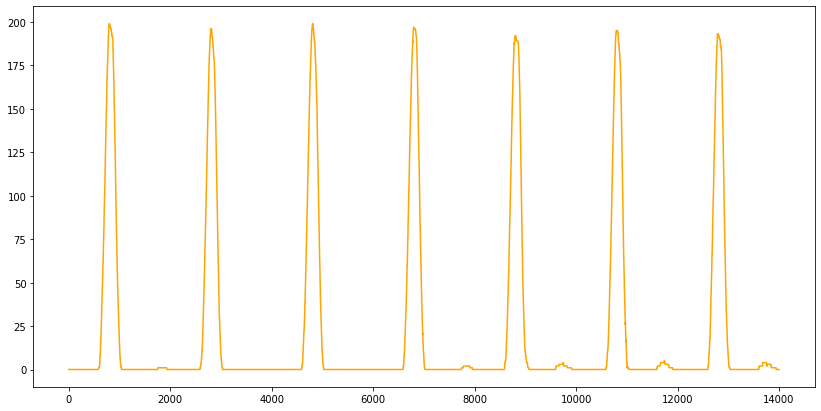

In [66]:
# plot the given data for the MI building utilization
plt.plot(x_original[:,0], c='orange')

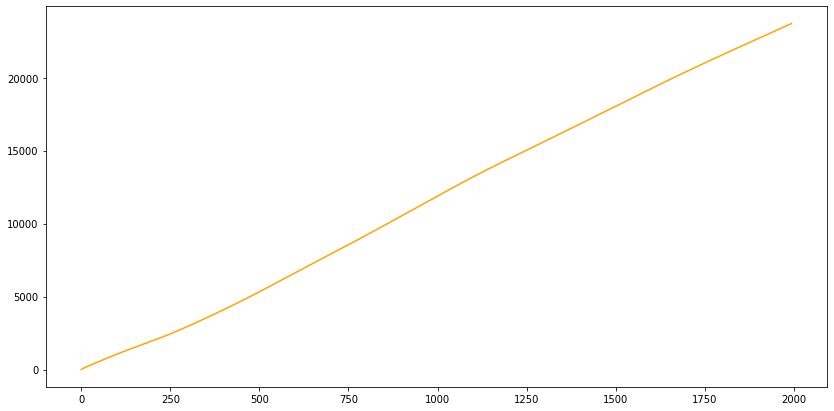

In [49]:
pred_mi = []
point = x_original[0,1]
pred_mi.append(point)
for i in range(len(period_speeds)):
    point += period_speeds[i]
    pred_mi.append(point)
plt.plot(pred_mi, c='orange')

<IPython.core.display.Javascript object>


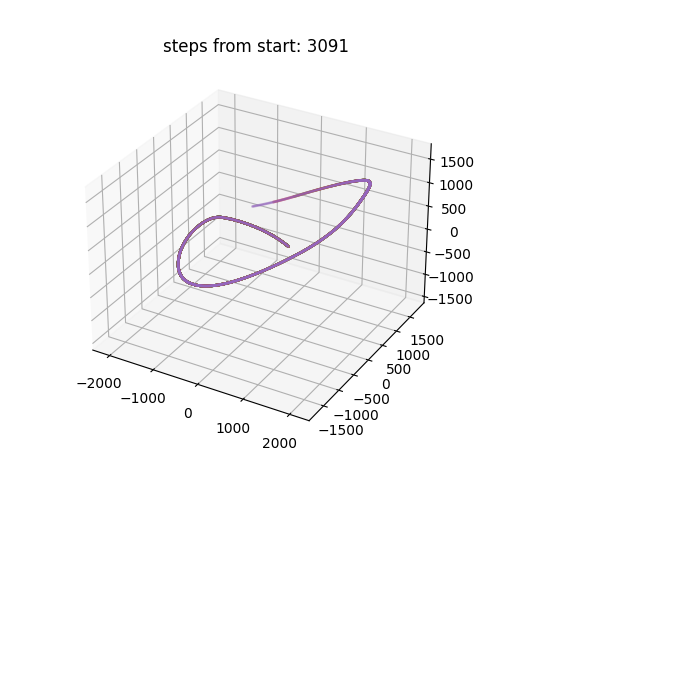

KeyboardInterrupt: 

In [22]:
import time
%matplotlib notebook
plt.rcParams["figure.figsize"] = (14,7)
figure, axs = plt.subplots(1,1,figsize=(5,5), subplot_kw=dict(projection='3d'))
for i in [int(j) for j in np.linspace(0, x_pca.shape[0], 500)]:
    axs.scatter(*x_pca[:i,:].T, s=1)
    figure.canvas.draw()
 
    # This will run the GUI event
    # loop until all UI events
    # currently waiting have been processed
    axs.set_title(f"steps from start: {i}")
    figure.canvas.flush_events()
    time.sleep(0.1)